In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

Cleaning Dataset

In [2]:
df = pd.read_csv('pollution_data.csv')
df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at'] = df['created_at'].dt.tz_localize(None)

df

,created_at,Temperature,Humidity,PM2.5,PM10,CO,CO2
0,2025-06-21 07:00:15,24.8,84.3,52.7,72.5,0.59860,403.34171
1,2025-06-21 07:01:04,24.8,84.1,50.4,66.7,0.56109,403.40472
2,2025-06-21 07:01:53,24.8,84.0,51.7,74.0,0.54466,403.36261
3,2025-06-21 07:02:43,24.9,83.6,49.7,65.9,0.55447,403.30020
4,2025-06-21 07:03:32,24.9,83.3,51.6,72.7,0.57113,403.29333
...,...,...,...,...,...,...,...
62420,2025-07-28 06:55:48,25.7,77.3,60.4,89.8,8.19941,411.28958
62421,2025-07-28 06:56:41,25.8,77.0,59.8,88.2,8.21437,411.35828
62422,2025-07-28 06:57:35,25.8,76.8,61.0,92.7,8.12498,411.18726
62423,2025-07-28 06:58:24,25.8,76.5,60.2,90.9,8.15468,411.41003


In [3]:
df = df.drop(columns=['Temperature', 'Humidity'])
df['created_at'] = df['created_at'].dt.floor('min')
df = df[df['created_at'].dt.minute % 3 == 0]
df = df.drop_duplicates(subset='created_at', keep='first')
df = df.rename(columns={'created_at':'datetime'})
df.set_index('datetime', inplace=True)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['minute'] = df.index.minute
df

,PM2.5,PM10,CO,CO2,hour,dayofweek,minute
datetime,,,,,,,
2025-06-21 07:00:00,52.7,72.5,0.59860,403.34171,7,5,0
2025-06-21 07:03:00,51.6,72.7,0.57113,403.29333,7,5,3
2025-06-21 07:06:00,50.2,67.4,0.55119,403.32782,7,5,6
2025-06-21 07:09:00,54.5,74.4,0.58302,403.24551,7,5,9
2025-06-21 07:12:00,55.0,72.6,0.53658,403.36960,7,5,12
...,...,...,...,...,...,...,...
2025-07-28 06:45:00,52.4,80.0,7.34412,410.49396,6,0,45
2025-07-28 06:48:00,53.6,84.1,7.20935,410.60675,6,0,48
2025-07-28 06:51:00,61.7,90.6,7.64829,410.65543,6,0,51


In [4]:
features = ['PM2.5', 'PM10', 'CO', 'CO2', 'hour', 'minute', 'dayofweek']
features_y = ['PM2.5', 'PM10', 'CO', 'CO2']
data_X = df[features].dropna()
data_y = df[features_y].dropna()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data_X)
y_scaled = scaler_y.fit_transform(data_y)

X_scaled.shape, y_scaled.shape

((17388, 7), (17388, 4))

In [5]:
joblib.dump(scaler_X, 'scaler_X.save')
joblib.dump(scaler_y, 'scaler_y.save')

['scaler_y.save']

In [6]:
def create_sequences(X_data, y_data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(X_data) - n_steps_in - n_steps_out + 1):
      X.append(X_data[i:i+n_steps_in])
      y.append(y_data[i+n_steps_in:i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

n_in = 20
n_out = 20

X, y = create_sequences(X_scaled, y_scaled, n_in, n_out)

X.shape,y.shape

((17349, 20, 7), (17349, 20, 4))

In [7]:
X.shape

(17349, 20, 7)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = X.shape[2]

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13879, 20, 7), (3470, 20, 7), (13879, 20, 4), (3470, 20, 4))

In [9]:
split_index

13879

In [10]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_in, n_features),))
model.add(RepeatVector(n_out))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(y.shape[2]))) # Changed to y.shape[2] to match the number of output features
model.summary()

c:\Users\Muhammad Mahdi\anaconda3\envs\prediksi-polusi\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 4)          │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,732 (788.02 KB)

 Trainable params: 201,732 (788.02 KB)

 Non-trainable params: 0 (0.00 B)

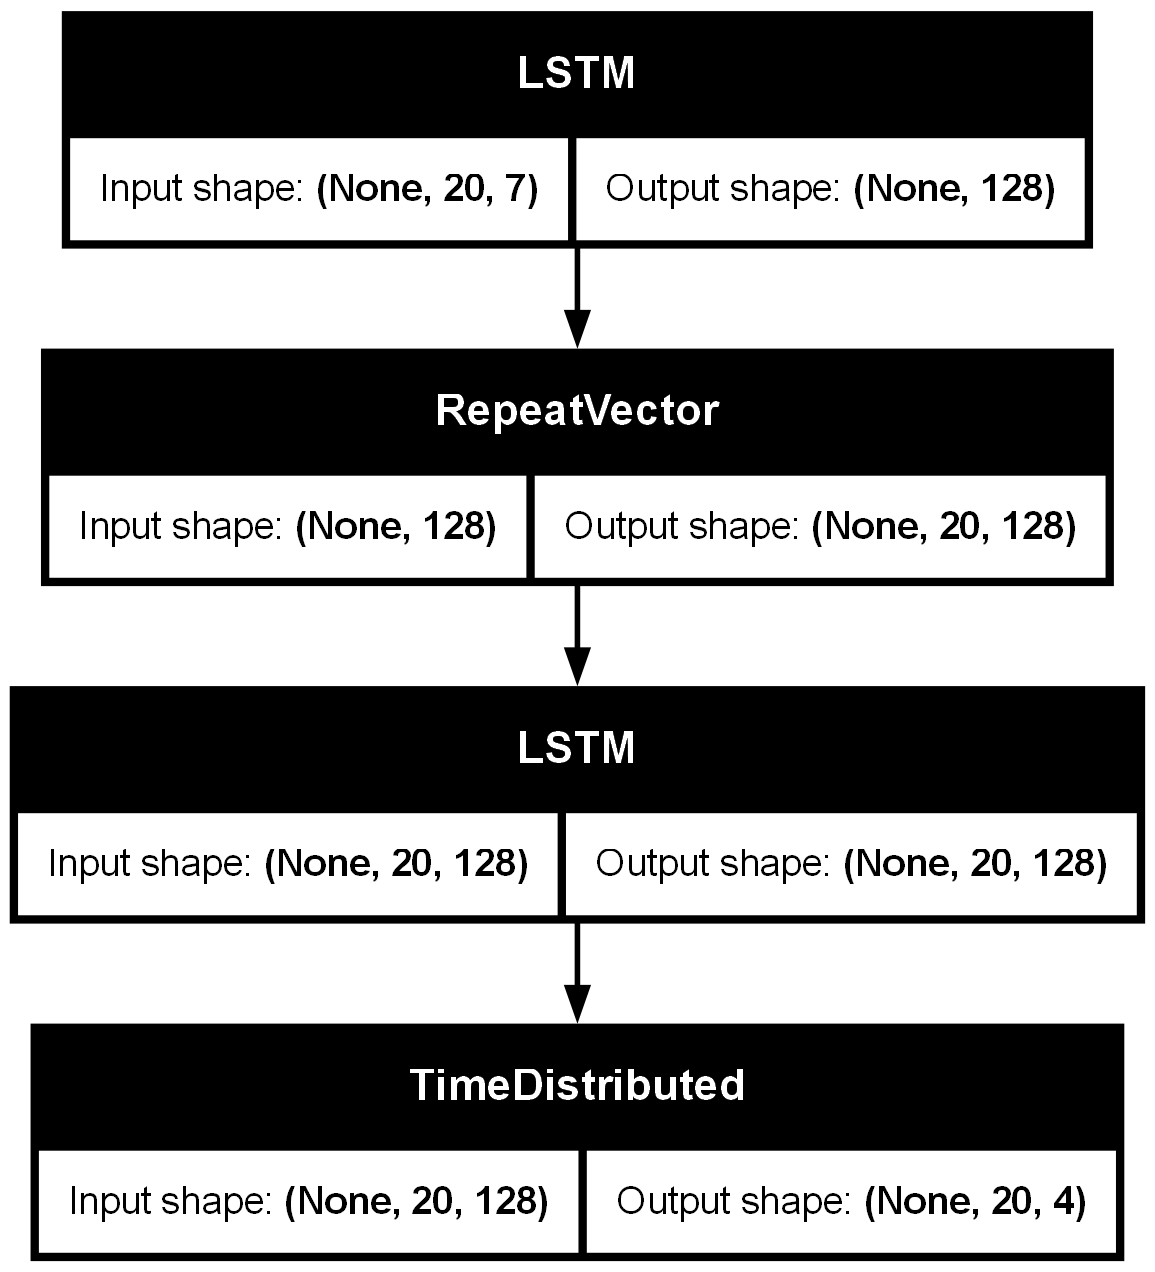

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
tf.random.set_seed(42)
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.compile(optimizer='adam', loss=MeanSquaredError())

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 2/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 3/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 4/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 5/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0017 - val_loss: 0.0075
Epoch 6/50
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0016 - val_loss: 0.0089
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [13]:
# model.save("lstm_model.h5")

In [30]:
model = load_model("lstm_model.h5", compile=False)

In [31]:
y_pred_scaled = model.predict(X_train).reshape(-1, y.shape[2])
y_true_scaled = y_train.reshape(-1, y.shape[2])

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

def modified_mape(y_true, y_pred, epsilon=1e-2):
    y_true = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

for i, name in enumerate(features_y):
    y_true_f = y_true[:, i]
    y_pred_f = y_pred[:, i]

    mae = mean_absolute_error(y_true_f, y_pred_f)
    rmse = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
    mape = modified_mape(y_true_f, y_pred_f)
    r2 = r2_score(y_true_f, y_pred_f)
    acc = max(0, 100 - mape)

    print(f"🔍 Evaluasi untuk {name}")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}")
    print(f"  R²  : {r2:.2f}")
    print(f"  Acc : {acc:.2f}%")
    print("-" * 30)

434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
🔍 Evaluasi untuk PM2.5
  MAE : 4.94
  RMSE: 7.41
  MAPE: 23.26
  R²  : 0.92
  Acc : 76.74%
------------------------------
🔍 Evaluasi untuk PM10
  MAE : 7.76
  RMSE: 11.31
  MAPE: 27.02
  R²  : 0.92
  Acc : 72.98%
------------------------------
🔍 Evaluasi untuk CO
  MAE : 0.07
  RMSE: 0.10
  MAPE: 5.88
  R²  : 0.98
  Acc : 94.12%
------------------------------
🔍 Evaluasi untuk CO2
  MAE : 0.15
  RMSE: 0.22
  MAPE: 0.04
  R²  : 0.98
  Acc : 99.96%
------------------------------


In [32]:
data_y.iloc[:split_index]

,PM2.5,PM10,CO,CO2
datetime,,,,
2025-06-21 07:00:00,52.7,72.5,0.59860,403.34171
2025-06-21 07:03:00,51.6,72.7,0.57113,403.29333
2025-06-21 07:06:00,50.2,67.4,0.55119,403.32782
2025-06-21 07:09:00,54.5,74.4,0.58302,403.24551
2025-06-21 07:12:00,55.0,72.6,0.53658,403.36960
...,...,...,...,...
2025-07-20 17:39:00,16.3,27.4,2.17250,404.21341
2025-07-20 17:42:00,16.7,25.4,2.20693,403.95309
2025-07-20 17:45:00,20.2,29.8,2.24681,404.05695


In [33]:
y_train.shape

(277580, 4)

In [34]:
y_true.shape

(277580, 4)

In [35]:
y_pred.shape

(277580, 4)

In [36]:
y_true

array([[ 90.6    , 119.2    ,   0.65098, 403.81088],
       [ 95.4    , 124.4    ,   0.66036, 403.76477],
       [ 97.6    , 129.89999,   0.61806, 403.85745],
       ...,
       [ 25.9    ,  39.8    ,   2.2975 , 404.22064],
       [ 24.     ,  37.3    ,   2.36478, 404.29358],
       [ 46.1    ,  72.2    ,   2.37527, 404.16309]])

In [37]:
# Ambil waktu target Y dari raw dataframe
start_index = n_in
end_index = n_in + n_out

# Lihat 1 sampel y dari hasil sequence:
first_target = data_y.iloc[start_index:end_index]
first_target

,PM2.5,PM10,CO,CO2
datetime,,,,
2025-06-21 08:00:00,90.6,119.20000,0.65098,403.81088
2025-06-21 08:03:00,95.4,124.40000,0.66036,403.76477
2025-06-21 08:06:00,97.6,129.89999,0.61806,403.85745
2025-06-21 08:09:00,95.4,123.30000,0.59685,403.84967
2025-06-21 08:12:00,93.9,122.60000,0.60386,403.74951
2025-06-21 08:15:00,91.8,119.70000,0.61806,403.80316
2025-06-21 08:21:00,87.5,114.00000,0.58991,403.81860
2025-06-21 08:24:00,84.9,116.50000,0.61093,403.52637
2025-06-21 08:27:00,82.3,109.00000,0.60562,403.80316


In [38]:
y_pred_scaled = model.predict(X_train).reshape(-1, y.shape[2])
y_true_scaled = y_train.reshape(-1, y.shape[2])

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

def modified_mape(y_true, y_pred, epsilon=1e-2):
    y_true = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

for i, name in enumerate(features_y):
    y_true_f = y_true[:, i]
    y_pred_f = y_pred[:, i]

    mae = mean_absolute_error(y_true_f, y_pred_f)
    rmse = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
    mape = mean_absolute_percentage_error(y_true_f, y_pred_f)
    r2 = r2_score(y_true_f, y_pred_f)
    acc = max(0, 100 - mape)

    print(f"🔍 Evaluasi untuk {name}")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}")
    print(f"  R²  : {r2:.2f}")
    print(f"  Acc : {acc:.2f}%")
    print("-" * 30)

434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
🔍 Evaluasi untuk PM2.5
  MAE : 4.94
  RMSE: 7.41
  MAPE: 3422678616840.83
  R²  : 0.92
  Acc : 0.00%
------------------------------
🔍 Evaluasi untuk PM10
  MAE : 7.76
  RMSE: 11.31
  MAPE: 4557807736259.84
  R²  : 0.92
  Acc : 0.00%
------------------------------
🔍 Evaluasi untuk CO
  MAE : 0.07
  RMSE: 0.10
  MAPE: 0.06
  R²  : 0.98
  Acc : 99.94%
------------------------------
🔍 Evaluasi untuk CO2
  MAE : 0.15
  RMSE: 0.22
  MAPE: 0.00
  R²  : 0.98
  Acc : 100.00%
------------------------------


In [39]:
train_pred_scaled = model.predict(X_train)
train_pred_scaled = train_pred_scaled.reshape(-1, y.shape[2]) # Reshape to 2D
train_pred = scaler_y.inverse_transform(train_pred_scaled)
y_train = y_train.reshape(-1, y.shape[2]) # Reshape to 2D
y_train_unscaled = scaler_y.inverse_transform(y_train)
train_results = pd.DataFrame({
    'Prediction': train_pred[:20].flatten(),
    'Actual': y_train_unscaled[:20].flatten()
})

train_results

434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


,Prediction,Actual
0,83.506393,90.60000
1,117.330055,119.20000
2,0.779741,0.65098
3,403.883118,403.81088
4,89.961472,95.40000
...,...,...
75,403.818939,403.66641
76,97.444077,91.40000
77,130.689987,121.80000
78,0.686239,0.63435


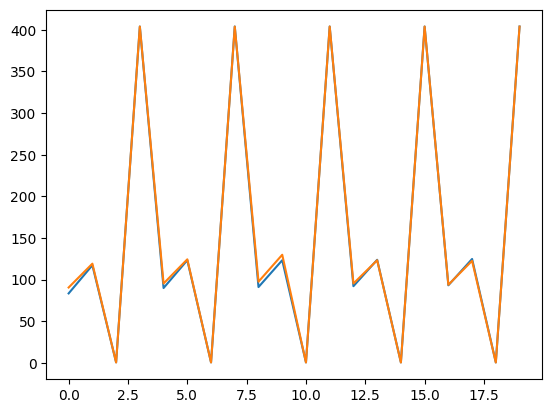

In [40]:
import matplotlib.pyplot as plt
plt.plot(train_results['Prediction'][:20])
plt.plot(train_results['Actual'][:20])

[[ 83.50639    117.330055     0.7797413  403.88312   ]
 [ 89.96147    123.3833       0.7246704  403.92996   ]
 [ 91.140236   123.33496      0.71287054 403.89725   ]
 ...
 [ 36.4505      62.54836      2.397594   404.19678   ]
 [ 36.507877    62.627537     2.3972385  404.19598   ]
 [ 36.565777    62.70966      2.3971553  404.1955    ]]
[[ 90.6     119.2       0.65098 403.81088]
 [ 95.4     124.4       0.66036 403.76477]
 [ 97.6     129.89999   0.61806 403.85745]
 ...
 [ 25.9      39.8       2.2975  404.22064]
 [ 24.       37.3       2.36478 404.29358]
 [ 46.1      72.2       2.37527 404.16309]]


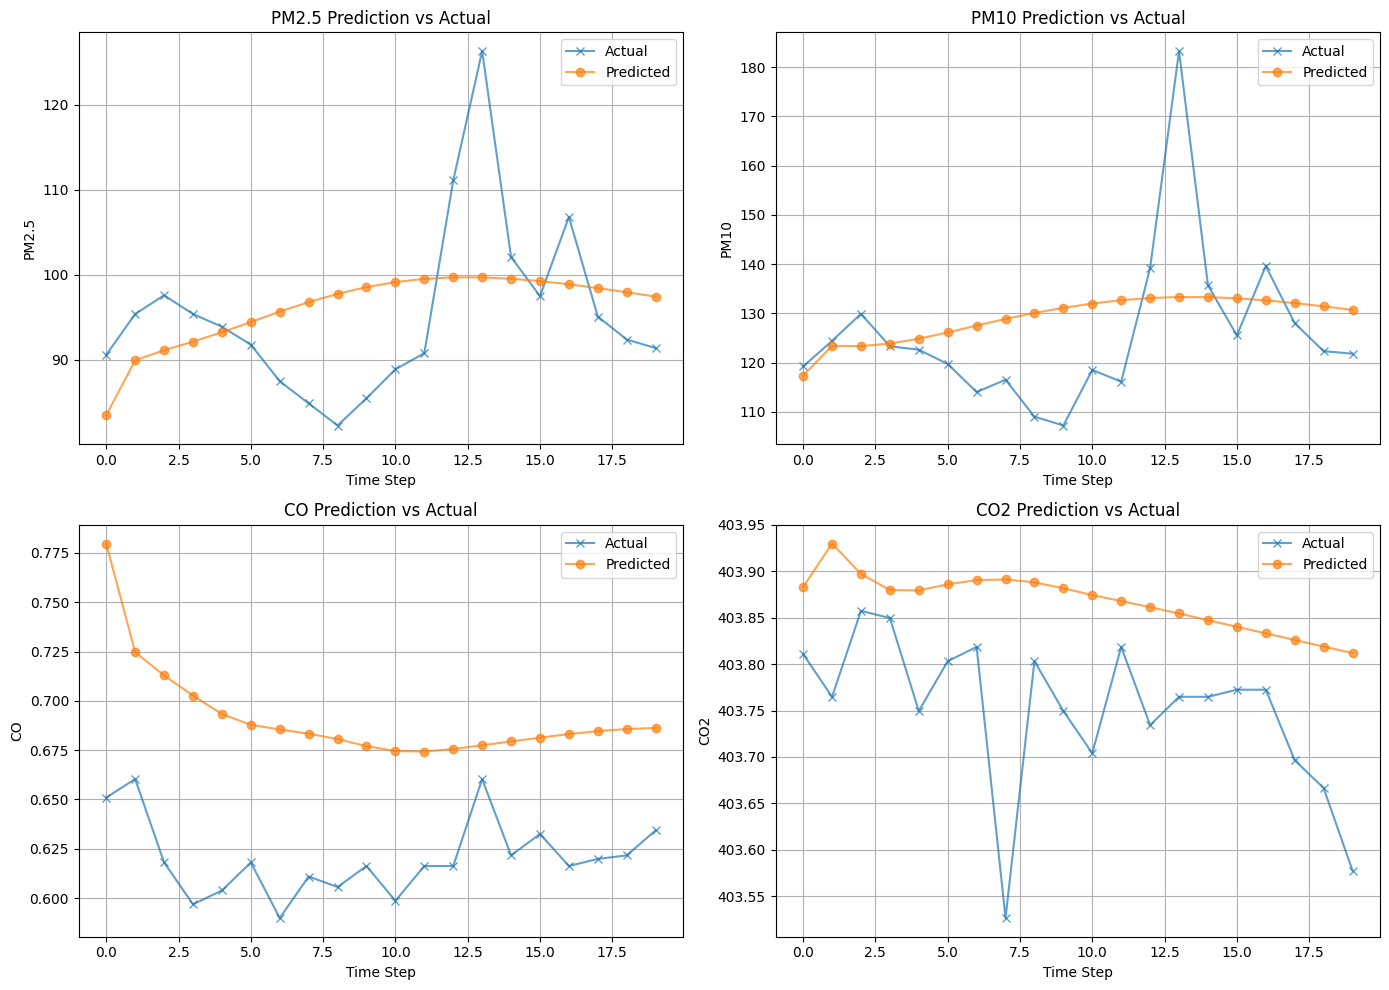

In [41]:
n_features = len(features_y)

plt.figure(figsize=(14, 10))

print(y_pred)
print(y_true)

for i in range(n_features):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true[:20, i], label='Actual', alpha=0.7, marker='x')
    plt.plot(y_pred[:20, i], label='Predicted', alpha=0.7, marker='o')
    plt.title(f'{features[i]} Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel(features[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
y_pred_scaled = model.predict(X_test).reshape(-1, y.shape[2])
y_true_scaled = y_test.reshape(-1, y.shape[2])

y_pred_test = scaler_y.inverse_transform(y_pred_scaled)
y_true_test = scaler_y.inverse_transform(y_true_scaled)

def modified_mape(y_true, y_pred, epsilon=1e-2):
    y_true = np.where(np.abs(y_true) < epsilon, epsilon, y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

for i, name in enumerate(features_y):
    y_true_f = y_true[:, i]
    y_pred_f = y_pred[:, i]

    mae = mean_absolute_error(y_true_f, y_pred_f)
    rmse = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
    mape = modified_mape(y_true_f, y_pred_f)
    r2 = r2_score(y_true_f, y_pred_f)
    acc = max(0, 100 - mape)

    print(f"🔍 Evaluasi untuk {name}")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}")
    print(f"  R²  : {r2:.2f}")
    print(f"  Acc : {acc:.2f}%")
    print("-" * 30)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
🔍 Evaluasi untuk PM2.5
  MAE : 4.94
  RMSE: 7.41
  MAPE: 23.26
  R²  : 0.92
  Acc : 76.74%
------------------------------
🔍 Evaluasi untuk PM10
  MAE : 7.76
  RMSE: 11.31
  MAPE: 27.02
  R²  : 0.92
  Acc : 72.98%
------------------------------
🔍 Evaluasi untuk CO
  MAE : 0.07
  RMSE: 0.10
  MAPE: 5.88
  R²  : 0.98
  Acc : 94.12%
------------------------------
🔍 Evaluasi untuk CO2
  MAE : 0.15
  RMSE: 0.22
  MAPE: 0.04
  R²  : 0.98
  Acc : 99.96%
------------------------------


In [43]:
test_pred_scaled = model.predict(X_test)
test_pred_scaled = test_pred_scaled.reshape(-1, y.shape[2]) # Reshape to 2D
test_pred = scaler_y.inverse_transform(test_pred_scaled)
y_test = y_test.reshape(-1, y.shape[2]) # Reshape to 2D
y_test_unscaled = scaler_y.inverse_transform(y_test)
test_results = pd.DataFrame({
    'Prediction': test_pred[:20].flatten(),
    'Actual': y_test_unscaled[:20].flatten()
})

test_results

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,Prediction,Actual
0,38.538170,22.70000
1,61.204605,39.00000
2,2.316536,2.40699
3,404.232849,404.21341
4,38.053505,22.30000
...,...,...
75,404.163269,404.16309
76,38.965996,39.10000
77,65.852051,67.30000
78,2.410771,2.40168


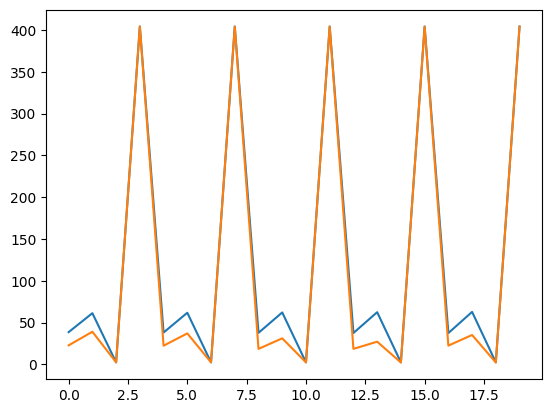

In [44]:
plt.plot(test_results['Prediction'][:20])
plt.plot(test_results['Actual'][:20])

[[ 38.53817    61.204605    2.3165357 404.23285  ]
 [ 38.053505   61.717922    2.327815  404.24594  ]
 [ 37.685524   62.092186    2.3510344 404.24838  ]
 ...
 [ 50.437927   86.87928     7.1261983 410.1414   ]
 [ 49.17486    85.38818     7.16567   410.15668  ]
 [ 48.043007   83.969795    7.18756   410.15686  ]]
[[ 22.7      39.        2.40699 404.21341]
 [ 22.3      37.        2.39109 404.08502]
 [ 18.5      31.1       2.35433 404.09912]
 ...
 [ 61.7      90.6       7.64829 410.65543]
 [ 60.3      92.2       7.9052  410.98508]
 [ 61.       92.7       8.12498 411.18726]]


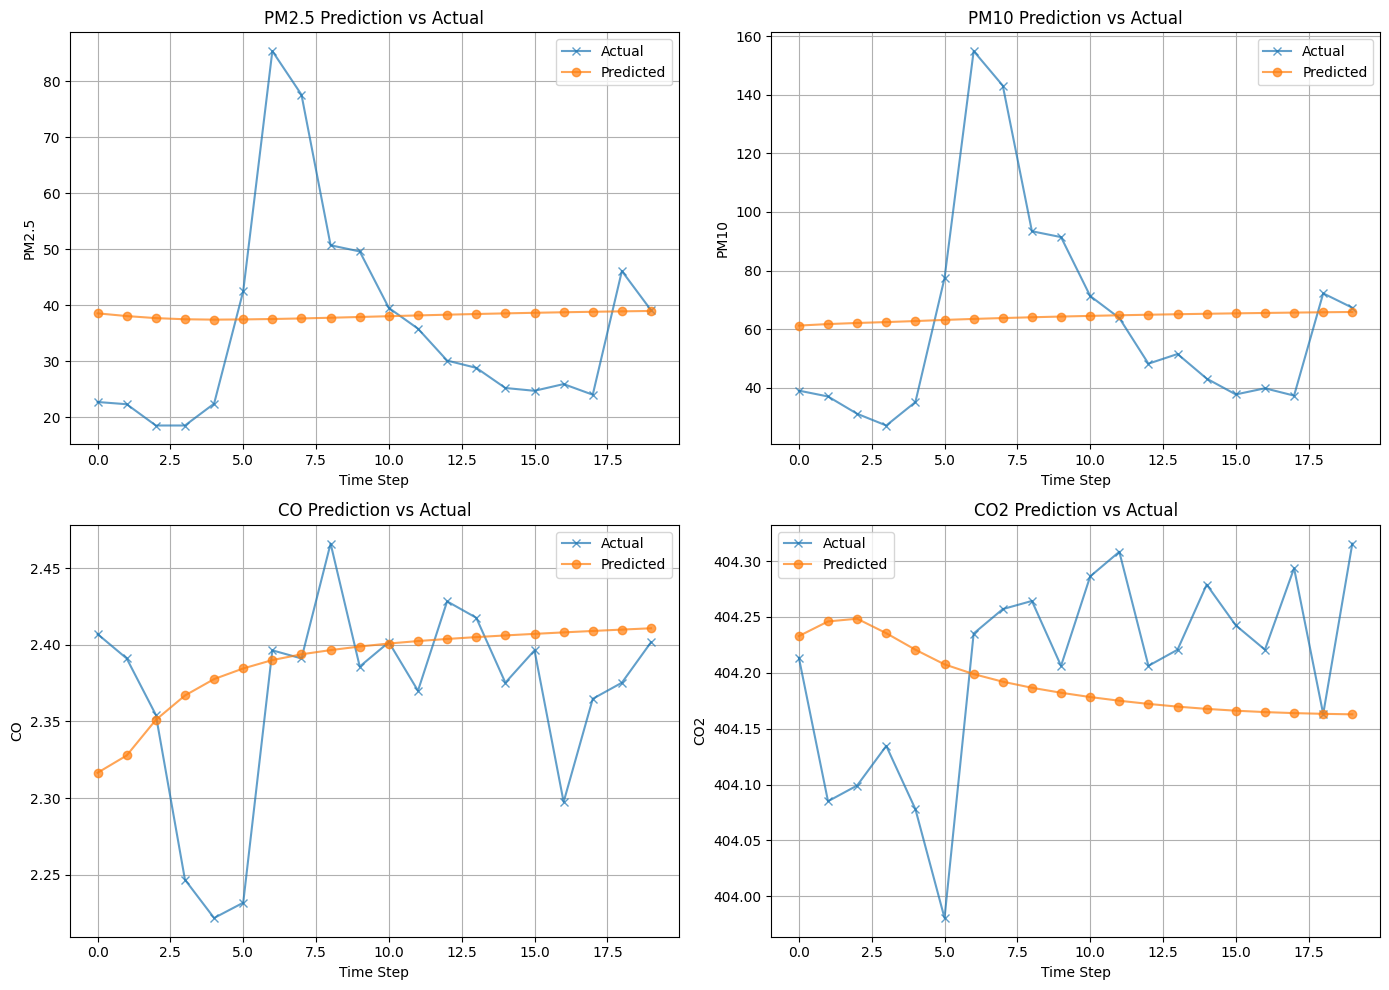

In [45]:
n_features = len(features_y)

plt.figure(figsize=(14, 10))

print(y_pred_test)
print(y_true_test)

for i in range(n_features):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true_test[:20, i], label='Actual', alpha=0.7, marker='x')
    plt.plot(y_pred_test[:20, i], label='Predicted', alpha=0.7, marker='o')
    plt.title(f'{features[i]} Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel(features[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()